In [1]:
import calour as ca
import calour_utils as cu
import numpy as np

failed to load logging config file


In [2]:
ca.set_log_level(11)

In [3]:
%matplotlib inline

In [4]:
def rotate_exp(exp):
    '''rotate the samples/features
    '''
    newexp = exp.copy()
    newexp.data = newexp.data.T
    ss=newexp.sample_metadata
    newexp.sample_metadata=newexp.feature_metadata
    newexp.feature_metadata=ss
    return newexp

In [5]:
def flip_data(exp,axis='s'):
    if axis=='s':
        toflip=len(exp.sample_metadata)
    else:
        toflip=len(exp.feature_metadata)
    newexp=exp.reorder(np.arange(toflip-1,-1,-1), axis=axis)
    return newexp

# Load the data

In [6]:
# supress warning about samples without metadata
ca.set_log_level('ERROR')
dat=ca.read_amplicon('./all.cron.biom','./map.cron.txt',normalize=10000,min_reads=1000)
ca.set_log_level('INFO')

### remove reverse read sequences

In [8]:
badseqs=[]
for cseq in dat.feature_metadata.index.values:
    if cseq[:2]=='CC':
        badseqs.append(cseq)
print('%d bad sequences out of %d'% (len(badseqs), len(dat.feature_metadata)))

1887 bad sequences out of 4554


In [9]:
dat=dat.filter_ids(badseqs,negate=True)

In [10]:
datc=dat.cluster_features(10)

2021-06-06 14:05:43 INFO After filtering, 1980 remain.


### Get just the human samples

In [11]:
hum=datc.filter_samples('type','Hum').cluster_features(10)

2021-06-06 14:05:46 INFO After filtering, 1506 remain.


In [12]:
hum=hum.sort_samples('BMI category')

### let's look at the data

In [13]:
cu.splot(hum,'diet',barx_fields=['BMI category'])

creating logger


# Identify differentially abundant bacteria

### The significance level

In [14]:
alpha=0.01

### Only compare lean individuals, and choose one random sample per individual if more than one exists

In [15]:
tt=hum.filter_samples('BMI category','lean')
# tt=tt.aggregate_by_metadata('human_donor',agg='random')
tt=tt.downsample('human_donor',axis='s',keep=1,random_seed=2018)

### Number of samples in each group

In [16]:
tt.sample_metadata['diet'].value_counts()

AMER    66
CRON    33
Name: diet, dtype: int64

### Get the bacteria which are different

In [17]:
dd=tt.diff_abundance('diet','CRON','AMER',random_seed=2018, alpha=alpha)

2021-06-06 14:05:54 INFO 99 samples with both values
2021-06-06 14:05:54 INFO After filtering, 1332 remain.
2021-06-06 14:05:54 INFO 33 samples with value 1 (['CRON'])
2021-06-06 14:05:55 INFO number of higher in CRON: 141. number of higher in AMER : 28. total 169


### What we get

2021-06-06 14:05:56 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

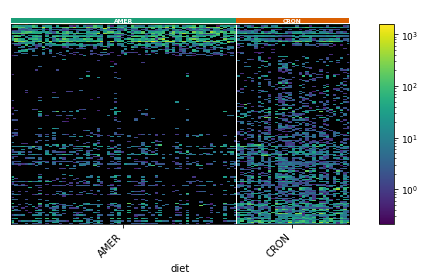

In [18]:
f=dd.sort_samples('diet').plot(sample_field='diet',gui='jupyter',barx_fields=['diet'])

In [19]:
f.save_figure('./caloric-restriction-diff-bact.pdf')

## The rotated heatmaps

2021-06-06 14:06:00 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

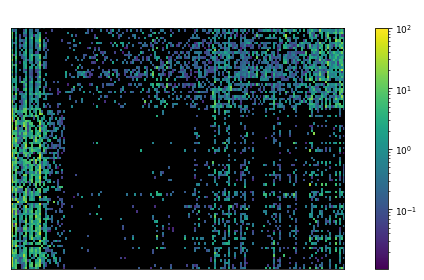

In [20]:
import numpy as np
# scale 100, sort by subject
tt=dd.normalize(100).sort_samples('diet')
# lets flip the order
tt=tt.reorder(np.arange(len(tt.feature_metadata)-1,0,-1), axis='f')
# and rotate
tt=rotate_exp(tt)
tt=flip_data(tt,'s')
tt=flip_data(tt,'f')
f=tt.plot(feature_field=None,gui='jupyter',clim=[0,100])

In [21]:
f.save_figure('./caloric-restriction-diff-bact-rotated.pdf')

### have a look to see these are not bmi related (even though we compared only to lean bmi)

In [22]:
f=hum.filter_ids(dd.feature_metadata.index).sort_samples('diet').plot(sample_field='diet',gui='qt5',barx_fields=['BMI category'])

# Plot the enriched terms

## the dbBact release to use

In [23]:
# max_id = 3925 # dbbact release 10-20
max_id = 6237 # dbbact release 2021.05

### The number of terms to show

In [24]:
numterms=6

In [25]:
db=ca.database._get_database_class('dbbact')

In [26]:
import matplotlib
matplotlib.rc('ytick', labelsize=15)

2021-06-06 14:06:13 INFO Getting dbBact annotations for 169 sequences, please wait...
2021-06-06 14:06:15 INFO got 1616 annotations
2021-06-06 14:06:15 WARNING ignoring 0 annotation with id > max_id 6237
2021-06-06 14:06:15 INFO Got 14960 annotation-sequence pairs
2021-06-06 14:06:15 INFO Added annotation data to experiment. Total 1616 annotations, 169 ASVs
2021-06-06 14:06:15 INFO Found 1 experiments ([293]) matching current experiment - ignoring them.
2021-06-06 14:06:17 INFO found 6 negative
2021-06-06 14:06:23 INFO found 6 positive


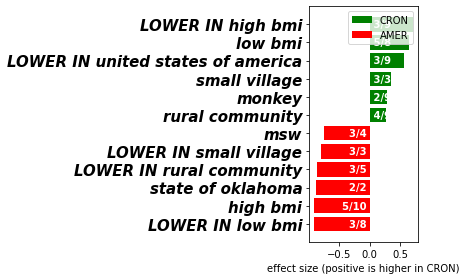

In [27]:
f,res = dd.plot_diff_abundance_enrichment(max_show=numterms,ignore_exp=True, use_term_pairs=False, colors=['green','red'], num_results_needed=numterms, min_appearances=2, random_seed=2018, max_id=max_id)

In [28]:
f.set_xlim([-1,1])

(-1.0, 1.0)

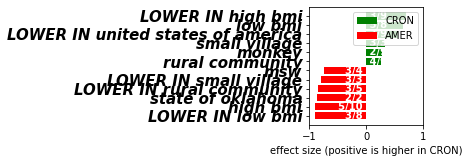

In [29]:
f.figure.set_size_inches(6.3,2)
f.figure

In [30]:
# save the csv table of the terms
res.feature_metadata.to_csv('./terms.csv')

In [31]:
f.figure.savefig('caloric-restriction-diff-terms.pdf')

In [32]:
f.figure.savefig('caloric-restriction-diff-terms.svg')

In [34]:
# save the tsv table of the terms
res.feature_metadata.to_csv('./terms-list.tsv',sep='\t')

# Create also the full enriched terms list for the supplementary table
we use min_appearances=1 so we'll get even the terms enriched in only 1 experiment (as opposed to the bar plot where we showed only the terms enriched in 2 experiments

In [35]:
positive = dd.feature_metadata['_calour_stat'] > 0
positive = dd.feature_metadata.index.values[positive.values]

enriched, term_features, features = dd.enrichment(features=positive, dbname='dbbact', ignore_exp=True, random_seed=2018,max_id=max_id, min_appearances=1)

2021-06-06 14:07:12 INFO Found 1 experiments ([293]) matching current experiment - ignoring them.
2021-06-06 14:08:08 INFO found 411 negative
2021-06-06 14:08:20 INFO found 55 positive


In [36]:
enriched.to_csv('./all-enriched-terms.tsv',sep='\t')

## And the B/W per-term heatmap

In [36]:
tres=flip_data(res,'f')
tres=flip_data(tres,'s')

2021-05-17 11:52:31 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

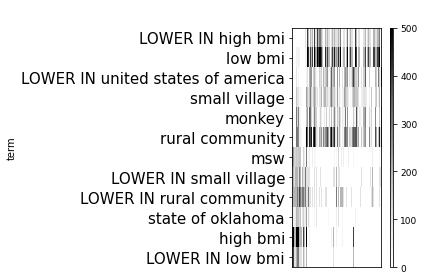

In [37]:
f=tres.plot(gui='jupyter',clim=[0,500],
            feature_field='term',yticklabel_kwargs={'rotation':0},yticklabel_len=35,
            cmap='Greys',norm=None)

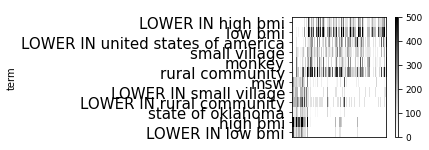

In [38]:
f.figure.set_size_inches(6.3,2)
f.figure

In [39]:
f.save_figure('./caloric-restriction-diff-terms-heatmap.pdf')

2021-05-17 11:52:32 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

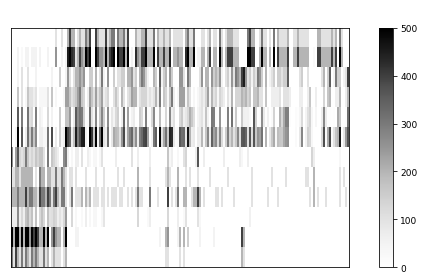

In [40]:
f=tres.plot(gui='jupyter',clim=[0,500], cmap='Greys',norm=None)

In [41]:
f.save_figure('./caloric-restriction-diff-terms-heatmap-no-labels.pdf')

# The BMI term zoom

In [42]:
db=ca.database._get_database_class('dbbact')

In [43]:
%matplotlib inline

2021-05-17 11:52:32 INFO found 20 annotations with the term ['low bmi']
2021-05-17 11:52:32 INFO annotation 1931 is low
2021-05-17 11:52:32 INFO annotation 974 is low
2021-05-17 11:52:33 INFO annotation 5147 is low
2021-05-17 11:52:33 INFO annotation 2913 is low
2021-05-17 11:52:33 INFO annotation 5096 is low
2021-05-17 11:52:33 INFO annotation 2865 is low
2021-05-17 11:52:33 INFO annotation 5232 is low
2021-05-17 11:52:33 INFO annotation 959 is low
2021-05-17 11:52:33 INFO ignored 0 annotations


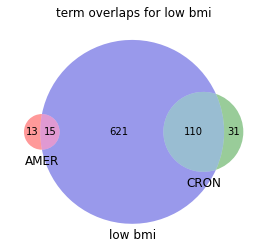

In [44]:
f=db.plot_term_venn_all('low bmi',dd,max_id=max_id,use_exact=True)

In [45]:
f.savefig('./venn-low-bmi.pdf')

2021-05-17 11:52:33 INFO found 20 annotations with the term ['high bmi']
2021-05-17 11:52:33 INFO annotation 960 is low
2021-05-17 11:52:33 INFO annotation 1667 is low
2021-05-17 11:52:33 INFO annotation 1930 is low
2021-05-17 11:52:33 INFO annotation 975 is low
2021-05-17 11:52:33 INFO annotation 5148 is low
2021-05-17 11:52:33 INFO annotation 2912 is low
2021-05-17 11:52:33 INFO annotation 5095 is low
2021-05-17 11:52:33 INFO annotation 2864 is low
2021-05-17 11:52:33 INFO annotation 5233 is low
2021-05-17 11:52:34 INFO ignored 0 annotations


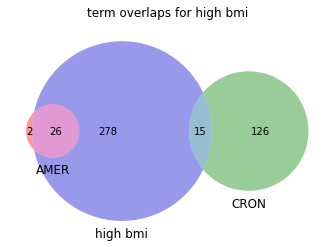

In [46]:
f=db.plot_term_venn_all('high bmi',dd,max_id=max_id,use_exact=True)

In [47]:
f.savefig('./venn-high-bmi.pdf')

# Also let's view this as a heatmap for the term annotations for sequences in both groups

In [50]:
db.show_term_details_diff('low bmi',dd,gui='qt5')

AmpliconExperiment with 18 samples, 169 features